In [5]:
import pandas as pd
import numpy as np
import os
import sys
from random import randrange
import scipy
from datetime import datetime
from keras.callbacks import EarlyStopping
import librosa # For analyzing audio and music, extracting the data from the audio files
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder , MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from IPython.display import Audio # To play the audio files
from keras.models import Sequential
from tensorflow.keras import layers, models, callbacks, regularizers
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import concurrent.futures
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
import pickle
import json
import warnings
warnings.filterwarnings('ignore')
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [6]:
# Complete imports for Speech Sentiment Analysis Training

# Core data processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle

# Audio processing
import librosa
import librosa.display
import soundfile as sf

# Deep learning - TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D,
    Flatten, LSTM, Dropout, BatchNormalization, Reshape, 
    concatenate, Activation
)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, 
    TensorBoard, CSVLogger
)
from tensorflow.keras.utils import to_categorical, plot_model

# Parallel processing and utilities
import concurrent.futures
import time
import os
import warnings
warnings.filterwarnings('ignore')

# System utilities
import sys
from pathlib import Path
import glob
import random

# Optional: for advanced visualization
from IPython.display import Audio, display
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Optional: for model analysis
from tensorflow.keras.utils import plot_model
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize


In [7]:
import numpy as np

In [8]:
data_df=pd.read_csv(r"data\afterReadingDataSet.csv")

In [9]:
# Checking label counts
data_df.Emotions.value_counts()

Emotions
happy       1923
sad         1923
angry       1923
fear        1923
disgust     1922
neutral     1703
surprise     652
calm         192
Name: count, dtype: int64

Might Drop surprise and calm for having low number of samples

nutral and calm are similer and they will be combined

In [70]:
# Combining neutral and calm instances
data_df.loc[data_df['Emotions'] == 'neutral','Emotions'] = "calm"
# dropping surprise 
data_df = data_df[data_df['Emotions'] != 'surprise']
data_df.Emotions.value_counts()

Emotions
happy      1923
sad        1923
angry      1923
fear       1923
disgust    1922
calm       1895
Name: count, dtype: int64

In [71]:
# Drop null values
print(data_df.isnull().sum())
data_df.dropna(inplace=True)
print(f"Null values in dataframe: {sum(data_df.isnull().sum())}")
print(f"Shape of dataframe: {data_df.shape}")

Emotions    0
Path        0
dtype: int64
Null values in dataframe: 0
Shape of dataframe: (11509, 2)


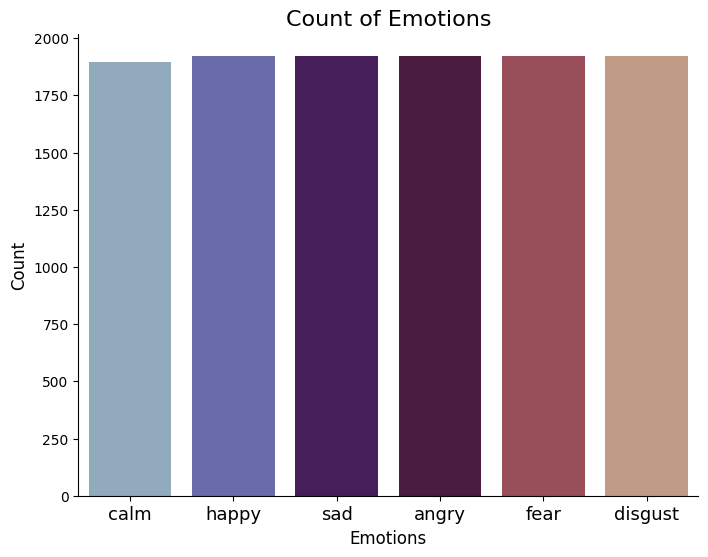

In [72]:
# Plot to see counts of labels
plt.figure(figsize=(8 ,6))
plt.title('Count of Emotions', size=16)
# Google drive plot
sns.countplot(data=data_df, x="Emotions", hue="Emotions", palette="twilight", legend=False)
# Kaggle plot
# sns.countplot(data=data_df, x="Emotions")
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.tick_params(axis='x', labelsize=13)
plt.show()

In [73]:
# Function to plot waveform
def create_waveplot(data, sr, emo):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {emo} emotion', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.xlabel('Time(s)', size=12)
    plt.ylabel('Amplitude', size=12)
    plt.tick_params(axis='x', labelsize=10)
    plt.tick_params(axis='y', labelsize=10)
    plt.show()

# Function to plot spectrogram
def create_spectrogram(data, sr, emo):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    # Convert frequency into decibels
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(11, 3))
    plt.title(f'Spectrogram for audio with {emo} emotion', size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.xlabel('Time(s)', size=12)
    plt.ylabel('Hz', size=12)
    plt.tick_params(axis='x', labelsize=10)
    plt.tick_params(axis='y', labelsize=10)
    plt.colorbar()

# Combine all plot functions
def combine_plots(data, emo):
    # Randomly select data instance of given emotion
    data_path = data[data['Emotions'] == emo]['Path'].iloc[randrange(len(data[data['Emotions'] == emo]))]
    data, sr = librosa.load(data_path)
    create_waveplot(data, sr, emo)
    create_spectrogram(data, sr, emo)
    return data, sr

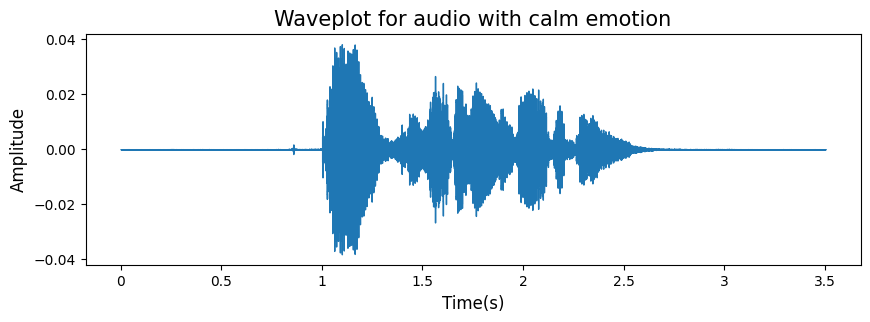

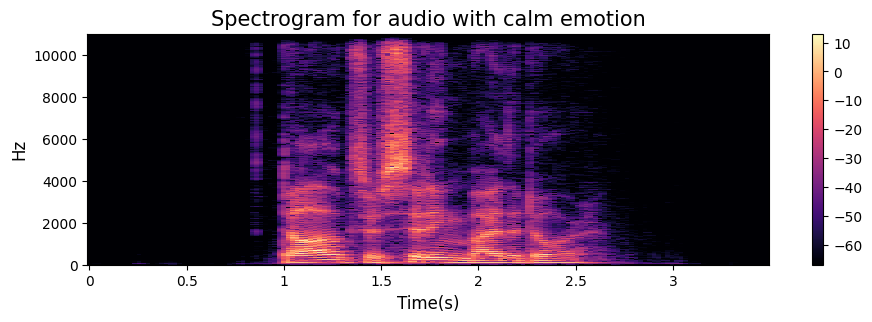

In [74]:
emo = 'calm'
data, sr = combine_plots(data_df, emo)
Audio(data, rate=sr)

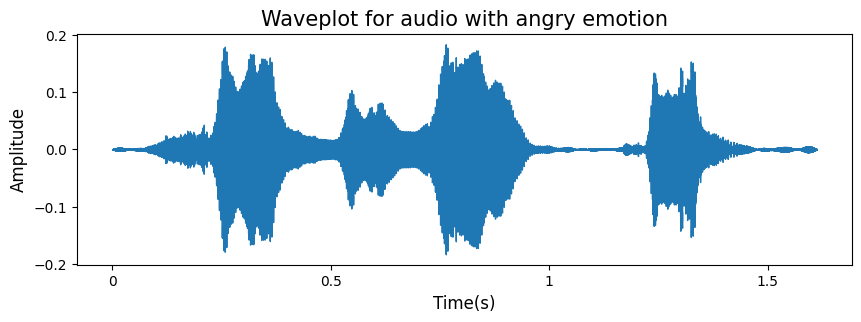

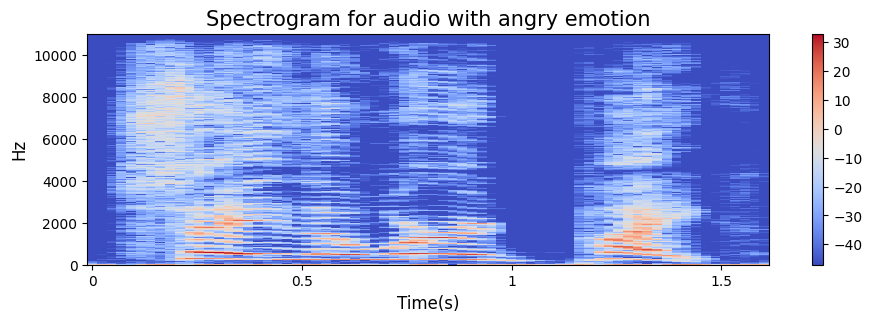

In [75]:
emo = "angry"
data, sr = combine_plots(data_df, emo)
Audio(data, rate=sr)

In [76]:
def noise(data, noise_factor=0.005):
    """Add noise to audio signal"""
    noise_amp = noise_factor * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=None):
    """Time stretch audio signal"""
    if rate is None:
        rate = np.random.uniform(0.8, 1.2)
    return librosa.effects.time_stretch(data, rate=rate)

def pitch_shift(data, sample_rate, n_steps=None):
    """Pitch shift audio signal"""
    if n_steps is None:
        n_steps = np.random.uniform(-2, 2)  # ±2 semitones
    return librosa.effects.pitch_shift(data, sr=sample_rate, n_steps=n_steps)

def volume_perturbation(data, gain_factor=None):
    """Apply volume changes"""
    if gain_factor is None:
        gain_factor = np.random.uniform(0.7, 1.3)
    return data * gain_factor

def time_shift(data, shift_max=0.2):
    """Shift audio in time"""
    shift = np.random.randint(-int(shift_max * len(data)), int(shift_max * len(data)))
    return np.roll(data, shift)

In [77]:
def extract_prosodic_features(data, sample_rate):
    """Extract prosodic features crucial for speech sentiment"""
    try:
        # Initialize all features as scalars
        features = []
        
        # Pitch-related features
        pitches, magnitudes = librosa.piptrack(y=data, sr=sample_rate)
        valid_pitches = pitches[pitches > 0]
        
        if len(valid_pitches) > 0:
            pitch_mean = float(np.mean(valid_pitches))
            pitch_std = float(np.std(valid_pitches))
            pitch_range = float(np.max(valid_pitches) - np.min(valid_pitches))
        else:
            pitch_mean = pitch_std = pitch_range = 0.0
        
        features.extend([pitch_mean, pitch_std, pitch_range])
        
        # Energy features
        rms = librosa.feature.rms(y=data)[0]
        energy_mean = float(np.mean(rms))
        energy_std = float(np.std(rms))
        energy_range = float(np.max(rms) - np.min(rms))
        
        features.extend([energy_mean, energy_std, energy_range])
        
        # Tempo and rhythm
        try:
            tempo, _ = librosa.beat.beat_track(y=data, sr=sample_rate)
            tempo = float(tempo) if not np.isscalar(tempo) else float(tempo)
        except:
            tempo = 120.0  # Default tempo if extraction fails
        
        features.append(tempo)
        
        # Speaking rate (zero crossing rate as proxy)
        zcr = librosa.feature.zero_crossing_rate(data)[0]
        speaking_rate = float(np.mean(zcr))
        
        features.append(speaking_rate)
        
        # Voice quality features - ensure scalar values
        centroid = librosa.feature.spectral_centroid(y=data, sr=sample_rate)[0]
        centroid_mean = float(np.mean(centroid))
        
        rolloff = librosa.feature.spectral_rolloff(y=data, sr=sample_rate)[0]
        rolloff_mean = float(np.mean(rolloff))
        
        bandwidth = librosa.feature.spectral_bandwidth(y=data, sr=sample_rate)[0]
        bandwidth_mean = float(np.mean(bandwidth))
        
        features.extend([centroid_mean, rolloff_mean, bandwidth_mean])
        
        # Simplified formant-like features
        # Use spectral centroid statistics instead of complex formant detection
        centroid_std = float(np.std(centroid))
        centroid_range = float(np.max(centroid) - np.min(centroid))
        
        features.extend([centroid_std, centroid_range])
        
        # Ensure we have exactly 13 features
        if len(features) != 13:
            print(f"Warning: Expected 13 features, got {len(features)}. Padding/truncating...")
            if len(features) < 13:
                features.extend([0.0] * (13 - len(features)))
            else:
                features = features[:13]
        
        # Convert to numpy array and ensure all values are finite
        features_array = np.array(features, dtype=np.float32)
        
        # Replace any NaN or inf values with 0
        features_array = np.nan_to_num(features_array, nan=0.0, posinf=0.0, neginf=0.0)
        
        return features_array
        
    except Exception as e:
        print(f"Error extracting prosodic features: {e}")
        return np.zeros(13, dtype=np.float32)  # Return zeros if extraction fails


In [78]:

def extract_speech_sentiment_features(data, sample_rate, n_mels=128, n_fft=2048, hop_length=512, max_len=130):
    """
    Extract optimized features for speech sentiment analysis
    
    Returns:
        mel_spectrogram: Primary feature for emotional prosody
        mfcc: Speech characteristics  
        prosodic_features: Pitch, energy, rhythm features
    """
    try:
        # 1. Mel Spectrogram (most important for emotion)
        mel_spec = librosa.feature.melspectrogram(
            y=data, sr=sample_rate, n_mels=n_mels, 
            n_fft=n_fft, hop_length=hop_length
        )
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        # 2. MFCC for speech characteristics
        mfcc = librosa.feature.mfcc(
            y=data, sr=sample_rate, n_mfcc=13,
            n_fft=n_fft, hop_length=hop_length
        )
        
        # 3. Prosodic features (NEW - very important for sentiment)
        prosodic_feats = extract_prosodic_features(data, sample_rate)
        
        # Pad or truncate spectrograms
        def pad_or_truncate(feature, max_len):
            if feature.shape[1] > max_len:
                return feature[:, :max_len]
            else:
                pad_width = max_len - feature.shape[1]
                return np.pad(feature, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
        
        mel_spec_db = pad_or_truncate(mel_spec_db, max_len)
        mfcc = pad_or_truncate(mfcc, max_len)
        
        return {
            'mel_spectrogram': mel_spec_db,      # (128, 130)
            'mfcc': mfcc,                        # (13, 130)
            'prosodic': prosodic_feats           # (13,) - 1D features
        }
        
    except Exception as e:
        print(f"Error in feature extraction: {e}")
        return {
            'mel_spectrogram': np.zeros((n_mels, max_len)),
            'mfcc': np.zeros((13, max_len)),
            'prosodic': np.zeros(13)
        }


In [79]:
def get_speech_sentiment_features(path, duration=3, offset=0.3):
    """
    Extract speech sentiment features with targeted augmentation
    """
    try:
        # Load audio
        data, sample_rate = librosa.load(path, duration=duration, offset=offset)
        
        # Targeted augmentations for speech sentiment
        augmented_data = [
            data,  # original
            noise(data.copy(), 0.003),           # Light noise (preserve speech)
            volume_perturbation(data.copy()),     # Volume changes (common in speech)
            pitch_shift(data.copy(), sample_rate, np.random.uniform(-1, 1)),  # Subtle pitch
            # Skip aggressive augmentations that destroy speech naturalness
        ]
        
        all_features = []
        
        for aug_data in augmented_data:
            features = extract_speech_sentiment_features(aug_data, sample_rate)
            all_features.append(features)
        
        return all_features
        
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return []

adding simple explanation of each feature to make it easier to understand

In [14]:
len(X), len(y)

NameError: name 'X' is not defined

In [ ]:
data_df = pd.DataFrame(X)
data_df["Labels"] = y
data_df.head()

,Labels


In [ ]:
#data_df.to_csv("data\combined.csv", index = False)

In [ ]:
data_df=pd.read_csv(r"data\combinedaftermodifications.csv")